In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['font.size'] = 20

%matplotlib inline

In [12]:
def f(N, M, q):
    assert N > M
    P = np.full((M + 1, N - M + 1), np.nan)
    P[M, N - M] = 1
    i = M - 1
    j = N - M
    while True:
        if i >= 0 and i <= M and j >= 0 and j <= N-M:
            P[i, j] = (P[i + 1, j] if i + 1 <= M else 0) * (i + 1) * q / ((i + 1) * q + j) + (P[i, j + 1] if j + 1 <= N - M and i != 0 else 0) * (j + 1) / (i * q + (j + 1))
        if i == 0 and j == 0:
            break
        if j - 1 < 0 :
            i = i + j - 1 - (N - M)
            j = N - M
        else:
            i = i + 1
            j = j - 1
    return P

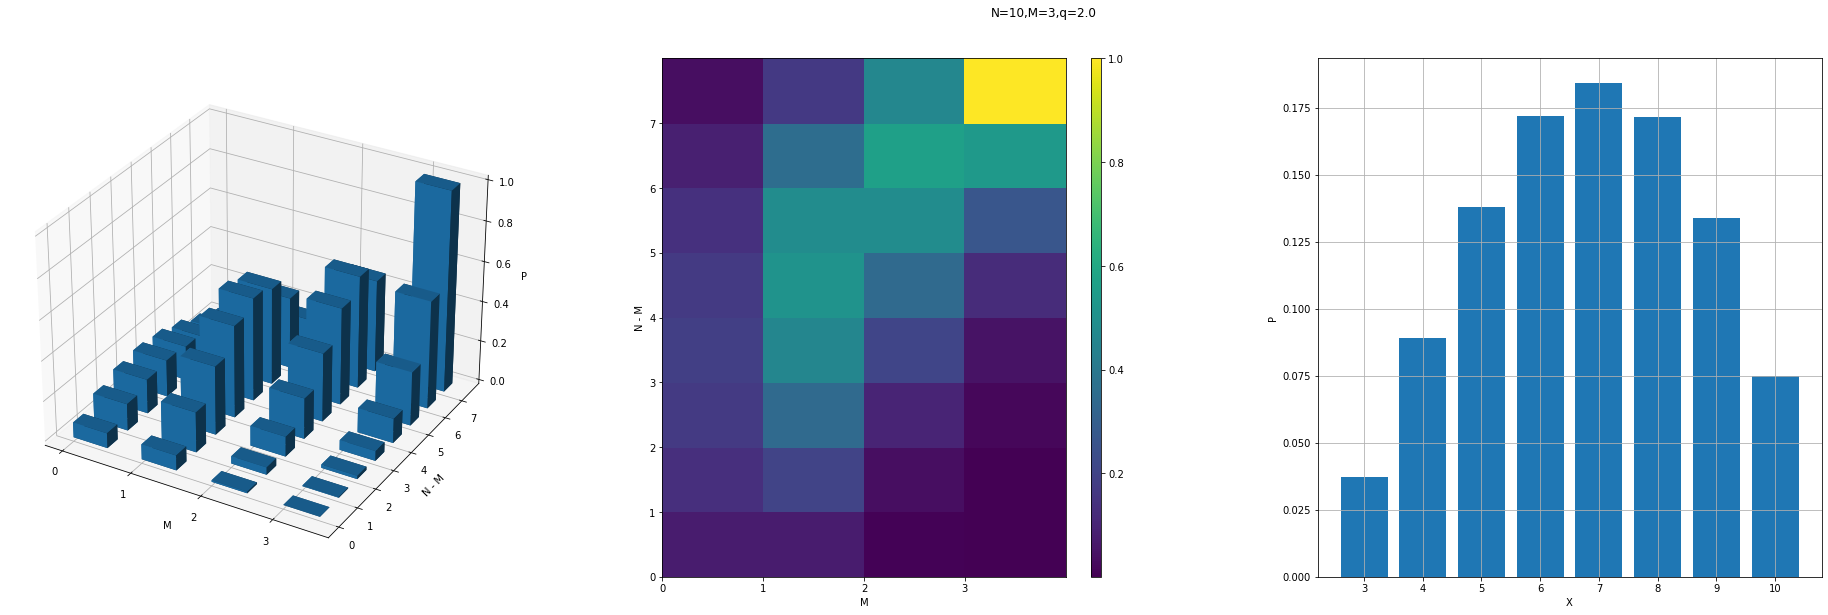

In [13]:
N = 10
M = 3
q = 2.0
P = f(N, M, q)
xpos, ypos = np.meshgrid(np.arange(M + 1), np.arange(N - M + 1), indexing='ij')
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = P.ravel()

plt.close()
fig = plt.figure(figsize=(36, 9))
gs = gridspec.GridSpec(1, 3, figure=fig, left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.3, hspace=0.35)
ax0 = fig.add_subplot(gs[0, 0], projection='3d')
ax0.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax0.set_xticks(np.arange(M + 1))
ax0.set_yticks(np.arange(N - M + 1))
ax0.set_xlabel('M')
ax0.set_ylabel('N - M')
ax0.set_zlabel('P')
ax1 = fig.add_subplot(gs[0, 1])
im = ax1.pcolormesh(np.arange(M + 2), np.arange(N - M + 2), P.T)
ax1.set_xticks(np.arange(M + 1))
ax1.set_yticks(np.arange(N - M + 1))
ax1.set_xlabel('M')
ax1.set_ylabel('N - M')
fig.colorbar(im, ax=ax1, aspect=50)
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(np.arange(N - M + 1) + M, P[0][::-1] / P[0].sum())
ax2.set_xticks(np.arange(N - M + 1) + M)
ax2.set_xlabel('X')
ax2.set_ylabel('P')
ax2.grid()
fig.suptitle('N={},M={},q={}'.format(N, M, q))
plt.savefig('nmq.png')